## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [5]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [6]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [7]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [9]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
print(data.shape)
data.head()

KeyError: "['name' 'ticket' 'boat' 'body' 'home.dest'] not found in axis"

In [10]:
# save the data set
data.to_csv('titanic.csv', index=False)

## 1. Data Exploration

### Find numerical and categorical variables

In [13]:
# we stock the column 'survive' in the target variable to be able to use it easily
target = 'survived'

In [15]:
vars_num = [var for var in data.columns if data[var].dtypes != 'O' and len(data[var].unique()) > 20]
vars_cat = [var for var in data.columns if len(data[var].unique()) < 20 or data[var].dtypes == 'O']


print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))
print('Numerical variables: ', vars_num)
print('Categorical variables: ', vars_cat)

Number of numerical variables: 2
Number of categorical variables: 8
Numerical variables:  ['age', 'fare']
Categorical variables:  ['pclass', 'survived', 'sex', 'sibsp', 'parch', 'cabin', 'embarked', 'title']


### Find missing values in variables

In [23]:
# first in numerical variables
vars_with_na_num = [var for var in vars_num if data[var].isnull().sum() > 0]
print("Percentage of null values in continuous numerical variables: ")
print()
print(data[vars_with_na_num].isnull().mean())

Percentage of null values in continuous numerical variables: 

age     0.200917
fare    0.000764
dtype: float64


In [24]:
# now in categorical variables
vars_with_na_cat = [var for var in vars_cat if data[var].isnull().sum() > 0]
print("Percentage of null values in categorical variables: ")
print()
print(data[vars_with_na_cat].isnull().mean())

Percentage of null values in categorical variables: 

cabin       0.774637
embarked    0.001528
dtype: float64


### Determine cardinality of categorical variables

In [25]:
data[vars_cat].nunique()

pclass        3
survived      2
sex           2
sibsp         7
parch         8
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

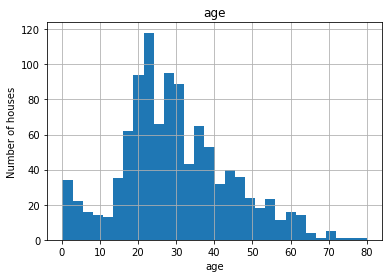

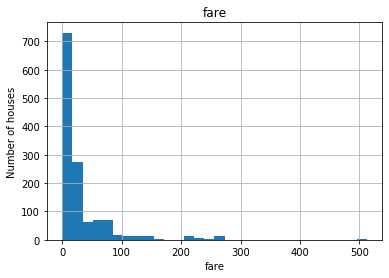

In [526]:
# Let's go ahead and analyse the distributions of these variables
def analyse_continuous(df, var):
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('Number of houses')
    plt.xlabel(var)
    plt.title(var)
    plt.show()


for var in vars_num:
    analyse_continuous(data, var)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## 2. Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [27]:
# train
X_train['cabin'] = X_train['cabin'].str[:1]
# test
X_test['cabin'] = X_test['cabin'].str[:1]

In [28]:
X_train.head(10)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr
44,1,female,41.0,0,0,134.5000,E,C,Miss
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss
574,2,male,29.0,1,0,21.0000,NaN,S,Mr
1217,3,male,19.0,0,0,7.6500,F,S,Mr
500,2,male,46.0,0,0,26.0000,NaN,S,Mr
958,3,female,NaN,0,4,25.4667,NaN,S,Mrs
269,1,male,NaN,0,0,26.0000,A,S,Mr
322,1,female,36.0,0,0,135.6333,C,C,Miss


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [29]:
X_train[vars_num].isnull().mean()

age     0.196753
fare    0.000955
dtype: float64

In [30]:
X_train['age'].median()

28.0

In [31]:
# replace engineer missing values as we described above
for var in vars_num:
    # calculate the mode using the train set
    median_val = X_train[var].median()

    # add binary missing indicator (in train and test)
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the median
    # (in train and test)
    X_train[var] = X_train[var].fillna(median_val)
    X_test[var] = X_test[var].fillna(median_val)

In [32]:
X_test[vars_num].isnull().sum()

age     0
fare    0
dtype: int64

In [33]:
X_test.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1139,3,male,38.0,0,0,7.8958,NaN,S,Mr,0,0
533,2,female,21.0,0,1,21.0000,NaN,S,Miss,0,0
459,2,male,42.0,1,0,27.0000,NaN,S,Mr,0,0
1150,3,male,28.0,0,0,14.5000,NaN,S,Mr,1,0
393,2,male,25.0,0,0,31.5000,NaN,S,Mr,0,0


### Replace Missing data in categorical variables with the string **Missing**

In [34]:
vars_cat.remove('survived')

In [35]:
# categorical
X_train[vars_cat] = X_train[vars_cat].fillna('Missing')
X_test[vars_cat] = X_test[vars_cat].fillna('Missing')

# vars_cat.remove('survived') # remove it because not in train nor test but in y now
# X_train[vars_cat].isnull().sum() # check no more NaN
X_test[vars_cat].isnull().sum() # check no more NaN

pclass      0
sex         0
sibsp       0
parch       0
cabin       0
embarked    0
title       0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [36]:
def find_frequent_labels(df, var, rare_perc):
    # function finds the labels that are shared by more than
    # a certain % of the passengers in the dataset

    df = df.copy()

    tmp = df.groupby(var)['age'].count() / len(df)

    return tmp[tmp > rare_perc].index

In [37]:
for var in vars_cat:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [38]:
X_test.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1139,3,male,38.0,0,0,7.8958,Missing,S,Mr,0,0
533,2,female,21.0,0,1,21.0000,Missing,S,Miss,0,0
459,2,male,42.0,1,0,27.0000,Missing,S,Mr,0,0
1150,3,male,28.0,0,0,14.5000,Missing,S,Mr,1,0
393,2,male,25.0,0,0,31.5000,Missing,S,Mr,0,0


In [39]:
for var in vars_cat:
    
    title_classes = X_train[var].unique()

    for i in title_classes:
        X_test[str(var) + '_' + str(i)] = np.where(X_test[str(var)] == i, 1, 0)   
        X_train[str(var) + '_' + str(i)] = np.where(X_train[str(var)] == i, 1, 0)
      
    X_test = X_test.drop([str(var)], axis = 1)
    X_train= X_train.drop([str(var)], axis = 1)

In [40]:
X_test.head()

,age,fare,age_na,fare_na,pclass_3,pclass_1,pclass_2,sex_male,sex_female,sibsp_0,sibsp_1,sibsp_3,sibsp_Rare,sibsp_4,sibsp_2,parch_0,parch_Rare,parch_1,parch_2,cabin_Missing,cabin_E,cabin_F,cabin_A,cabin_C,cabin_D,cabin_B,cabin_Rare,embarked_S,embarked_C,embarked_Q,embarked_Rare,title_Mr,title_Miss,title_Mrs,title_Other,title_Master
1139,38.0,7.8958,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
533,21.0,21.0000,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
459,42.0,27.0000,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1150,28.0,14.5000,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
393,25.0,31.5000,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


### Scale the variables

- Use the standard scaler from Scikit-learn

In [45]:
# capture all variables in a list
# except the target and the ID

train_vars = [var for var in X_train.columns]

# count number of variables
print("There are", len(train_vars), "variables in the table now:")
print()
print(train_vars)

There are 36 variables in the table now:

['age', 'fare', 'age_na', 'fare_na', 'pclass_3', 'pclass_1', 'pclass_2', 'sex_male', 'sex_female', 'sibsp_0', 'sibsp_1', 'sibsp_3', 'sibsp_Rare', 'sibsp_4', 'sibsp_2', 'parch_0', 'parch_Rare', 'parch_1', 'parch_2', 'cabin_Missing', 'cabin_E', 'cabin_F', 'cabin_A', 'cabin_C', 'cabin_D', 'cabin_B', 'cabin_Rare', 'embarked_S', 'embarked_C', 'embarked_Q', 'embarked_Rare', 'title_Mr', 'title_Miss', 'title_Mrs', 'title_Other', 'title_Master']


In [46]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[train_vars]) 

# transform the train and test set
X_train[train_vars] = scaler.transform(X_train[train_vars])
X_test[train_vars] = scaler.transform(X_test[train_vars])

In [47]:
X_train.head()

,age,fare,age_na,fare_na,pclass_3,pclass_1,pclass_2,sex_male,sex_female,sibsp_0,sibsp_1,sibsp_3,sibsp_Rare,sibsp_4,sibsp_2,parch_0,parch_Rare,parch_1,parch_2,cabin_Missing,cabin_E,cabin_F,cabin_A,cabin_C,cabin_D,cabin_B,cabin_Rare,embarked_S,embarked_C,embarked_Q,embarked_Rare,title_Mr,title_Miss,title_Mrs,title_Other,title_Master
1118,-0.370162,-0.504782,-0.494921,-0.03092,0.911274,-0.576247,-0.506856,0.761042,-0.761042,0.699522,-0.576247,-0.124575,-0.120561,-0.128471,-0.18597,0.555653,-0.13595,-0.384742,-0.312225,0.551235,-0.188702,-0.13226,-0.13595,-0.283717,-0.188702,-0.228607,-0.069271,0.639650,-0.493425,-0.319539,-0.043748,0.869892,-0.500895,-0.435629,-0.162698,-0.216795
44,0.904029,1.971555,-0.494921,-0.03092,-1.097365,1.735366,-0.506856,-1.313987,1.313987,0.699522,-0.576247,-0.124575,-0.120561,-0.128471,-0.18597,0.555653,-0.13595,-0.384742,-0.312225,-1.814107,5.299371,-0.13226,-0.13595,-0.283717,-0.188702,-0.228607,-0.069271,-1.563355,2.026652,-0.319539,-0.043748,-1.149569,1.996425,-0.435629,-0.162698,-0.216795
1072,-0.131251,-0.508533,2.020526,-0.03092,0.911274,-0.576247,-0.506856,0.761042,-0.761042,0.699522,-0.576247,-0.124575,-0.120561,-0.128471,-0.18597,0.555653,-0.13595,-0.384742,-0.312225,0.551235,-0.188702,-0.13226,-0.13595,-0.283717,-0.188702,-0.228607,-0.069271,-1.563355,-0.493425,3.129507,-0.043748,0.869892,-0.500895,-0.435629,-0.162698,-0.216795
1130,-0.927621,-0.507717,-0.494921,-0.03092,0.911274,-0.576247,-0.506856,-1.313987,1.313987,0.699522,-0.576247,-0.124575,-0.120561,-0.128471,-0.18597,0.555653,-0.13595,-0.384742,-0.312225,0.551235,-0.188702,-0.13226,-0.13595,-0.283717,-0.188702,-0.228607,-0.069271,0.639650,-0.493425,-0.319539,-0.043748,-1.149569,1.996425,-0.435629,-0.162698,-0.216795
574,-0.051614,-0.248980,-0.494921,-0.03092,-1.097365,-0.576247,1.972948,0.761042,-0.761042,-1.429547,1.735366,-0.124575,-0.120561,-0.128471,-0.18597,0.555653,-0.13595,-0.384742,-0.312225,0.551235,-0.188702,-0.13226,-0.13595,-0.283717,-0.188702,-0.228607,-0.069271,0.639650,-0.493425,-0.319539,-0.043748,0.869892,-0.500895,-0.435629,-0.162698,-0.216795


## 3. Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [48]:
model = LogisticRegression(C = 0.0005, random_state=0)

In [49]:
model.fit(X_train, y_train)

LogisticRegression(C=0.0005, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 4. Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [50]:
# model.predict_proba(X_test)
y_test_pred = model.predict(X_test)

In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred)

array([[161,   1],
       [ 63,  37]], dtype=int64)

We have 161 true negatives, 37 true positives, 1 false positive and 63 false negative. That means our model under estimates the probability to die on the Titanic.

#### ROC Curve:

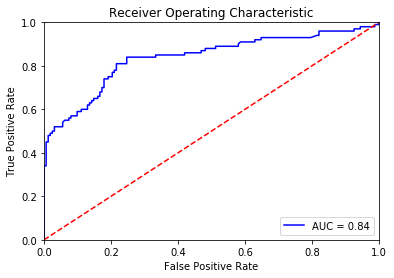

In [52]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**